In [1]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, _LRScheduler
from torch.optim import AdamW
import math
from rigl_torch.models import ModelFactory

net = ModelFactory.load_model("wide_resnet22", "cifar10")

In [1]:
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
import hydra

with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=[])
cfg

/tmp/ipykernel_235913/856747501.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="../configs"):


{'dataset': {'name': 'cifar10', 'normalize': False, 'num_classes': 10, 'classes': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']}, 'model': {'name': 'wide_resnet22'}, 'experiment': {'comment': None, 'name': '${model.name}_${dataset.name}_${experiment.comment}'}, 'paths': {'data_folder': '/home/condensed-sparsity/data', 'artifacts': '/home/condensed-sparsity/artifacts', 'logs': '/home/condensed-sparsity/logs'}, 'rigl': {'dense_allocation': None, 'delta': 100, 'grad_accumulation_n': 1, 'alpha': 0.3, 'static_topo': 0, 'const_fan_in': False, 'sparsity_distribution': 'erk', 'erk_power_scale': 1.0}, 'training': {'batch_size': 64, 'test_batch_size': 10, 'epochs': 50, 'lr': 1.0, 'init_lr': 1e-06, 'warm_up_steps': 5, 'gamma': 0.7, 'dry_run': False, 'seed': 1, 'log_interval': 10, 'save_model': True, 'weight_decay': 0, 'momentum': 0.9, 'optimizer': 'adadelta'}, 'compute': {'no_cuda': False, 'cuda_kwargs': {'num_workers': 1, 'pin_memory': True, 'shuffle'

In [3]:
from rigl_torch.models.resnet import ResNet18


In [2]:
ModelFactory.registered_models

{'mnist': {'mnist': <function rigl_torch.models.mnist.Mnist()>},
 'cifar10': {'wide_resnet22': <function rigl_torch.models.wide_resnet.get_wide_resnet_22()>}}

In [1]:
from rigl_torch.models import ModelFactory

net = ModelFactory.load_model("resnet18", "cifar10")
# net

In [2]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [3]:
from rigl_torch.util import get_W
W = get_W(net)

In [5]:
for x in W:
    print(x.shape)

torch.Size([16, 3, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 16, 1, 1])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 32, 1, 1])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([10, 128])


In [16]:
type(net.get_submodule("block1").get_submodule("layer").get_submodule("0"))

rigl_torch.models.wide_resnet.BasicBlock

In [28]:
import torch 
import torchvision
import rigl_torch
EXCLUDED_TYPES = (torch.nn.BatchNorm2d,)
other_types = [torchvision.models.resnet.Bottleneck, torchvision.models.resnet.BasicBlock, rigl_torch.models.wide_resnet.NetworkBlock, rigl_torch.models.wide_resnet.BasicBlock]

def get_weighted_layers_v2(model, i=0, layers=None, linear_layers_mask=None):
    if layers is None:
        layers = []
    if linear_layers_mask is None:
        linear_layers_mask = []

    items = model._modules.items()
    if i == 0:
        items = [(None, model)]

    for layer_name, p in items:
        if isinstance(p, torch.nn.Linear):
            layers.append([p])
            linear_layers_mask.append(1)
        elif hasattr(p, "weight") and type(p) not in EXCLUDED_TYPES:
            layers.append([p])
            linear_layers_mask.append(0)
        elif type(p) in other_types:
            _, linear_layers_mask, i = get_weighted_layers_v2(
                p, i=i + 1, layers=layers, linear_layers_mask=linear_layers_mask
            )
        else:
            _, linear_layers_mask, i = get_weighted_layers_v2(
                p, i=i + 1, layers=layers, linear_layers_mask=linear_layers_mask
            )

    return layers, linear_layers_mask, i


def get_W2(model, return_linear_layers_mask=False):
    layers, linear_layers_mask, _ = get_weighted_layers_v2(model)

    W = []
    for layer in layers:
        idx = 0 if hasattr(layer[0], "weight") else 1
        W.append(layer[idx].weight)

    assert len(W) == len(linear_layers_mask)

    if return_linear_layers_mask:
        return W, linear_layers_mask
    return W

In [29]:
W2 = get_W2(net )

In [31]:
for x in W2:
    print(x.shape)

torch.Size([16, 3, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 16, 1, 1])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 32, 1, 1])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([10, 128])


In [33]:
W == W2

True

In [32]:
for x in W:
    print(x.shape)

torch.Size([16, 3, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 16, 1, 1])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 32, 1, 1])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([10, 128])


In [182]:
import math
import numpy as np
from torch.optim.lr_scheduler import _LRScheduler


class CosineAnnealingWithLinearWarmUp(_LRScheduler):
    def __init__(
        self,
        optimizer,
        T_max,
        eta_min=0,
        last_epoch=-1,
        verbose=False,
        lr=0.001,
        warm_up_steps=20,
        init_lr=None,
    ):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warm_up_steps = warm_up_steps
        if init_lr is None:
            init_lr = 1e-6
        if lr is None:
            lr = optimizer.param_groups[0]["lr"]
        self.lr = lr
        self._linear_warmup_lrs = np.linspace(
            init_lr, self.lr, self.warm_up_steps
        )
        super().__init__(optimizer, last_epoch=last_epoch, verbose=verbose)

    def get_lr(self):
        if self.last_epoch < self.warm_up_steps:
            return [self._linear_warmup_lrs[self.last_epoch]] * len(
                self.optimizer.param_groups
            )

        elif (self.last_epoch - 1 - self.T_max) % (2 * self.T_max) == 0:
            return [
                group["lr"]
                + (self.lr - self.eta_min)
                * (1 - math.cos(math.pi / self.T_max))
                / 2
                for group in self.optimizer.param_groups
            ]
        return [
            (1 + math.cos(math.pi * self.last_epoch / self.T_max))
            / (1 + math.cos(math.pi * (self.last_epoch - 1) / self.T_max))
            * (group["lr"] - self.eta_min)
            + self.eta_min
            for group in self.optimizer.param_groups
        ]


In [184]:
T_max= 1000
adamw1 = AdamW(net.parameters(), lr=0.001)
adamw2 = AdamW(net.parameters(), lr=0.001)
cawr = CosineAnnealingWarmRestarts(optimizer=adamw1, T_0=20, T_mult=2)
ca = CosineAnnealingLR(optimizer=adamw2, T_max=T_max)
adamw3 = AdamW(net.parameters(), lr=0.001)
test= CosineAnnealingWithLinearWarmUp(optimizer=adamw3, T_max=T_max, warm_up_steps=50, lr=0.001)

In [185]:
test.get_last_lr()

[1e-06]

In [186]:
%matplotlib inline
warm_restart_lrs = []
ca_lrs = []
combined =[]
linear_warmup = []
for x in range(T_max):
    lr1 = cawr.get_last_lr()
    warm_restart_lrs.append(lr1)
    cawr.step()
    lr2 = ca.get_last_lr()
    ca_lrs.append(lr2)
    ca.step()
    combined.append(lr1[0] * lr2[0]*1000)
    lr3 = test.get_last_lr()
    linear_warmup.append(lr3)
    test.step()

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


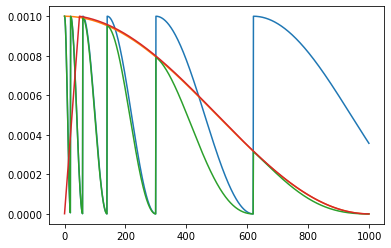

In [187]:
import matplotlib.pyplot as plt

plt.plot(warm_restart_lrs)
plt.plot(ca_lrs)
plt.plot(combined)
plt.plot(linear_warmup)

In [1]:
from rigl_torch.models import get_model
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
import hydra

In [2]:
with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=[])
cfg

/tmp/ipykernel_24187/3778961965.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="./configs"):


{'dataset': {'name': 'mnist', 'num_classes': 10}, 'model': {'name': 'mnist'}, 'experiment': {'name': '${model.name}_${dataset.name}_vanilla_rigl'}, 'paths': {'data_folder': '/home/condensed-sparsity/data', 'artifacts': '/home/condensed-sparsity/artifacts', 'logs': '/home/condensed-sparsity/logs'}, 'rigl': {'dense_allocation': 0.1, 'delta': 100, 'grad_accumulation_n': 1, 'alpha': 0.3, 'static_topo': 0, 'const_fan_in': True, 'sparsity_distribution': 'erk', 'erk_power_scale': 1.0}, 'training': {'batch_size': 64, 'test_batch_size': 10, 'epochs': 50, 'lr': 1.0, 'init_lr': 1e-06, 'warm_up_steps': 5, 'gamma': 0.7, 'dry_run': False, 'seed': 1, 'log_interval': 10, 'save_model': True}, 'compute': {'no_cuda': False, 'cuda_kwargs': {'num_workers': 1, 'pin_memory': True, 'shuffle': True}}, 'wandb': {'project': 'condensed-rigl', 'entity': 'condensed-sparsity', 'start_method': 'thread'}}

In [4]:
def print_image_shape(module, input, output):
    print(f"Module {module._get_name()}")
    print(f"input shape: {input[0].shape} output shape: {output.shape}")
    return output